In [2]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.utils.fixes import expit as sigmoid
from sklearn.ensemble.gradient_boosting import BinomialDeviance, ZeroEstimator

%matplotlib inline

/Users/Denis/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Loading datasets

In [3]:
DATASETS_PATH = '/Users/Denis/Google Диск/Datasets/'

def get_train_test(X, Y, test_rate=.2):
    idx_test = np.random.choice(Y.shape[0], Y.shape[0] * test_rate, replace=False)
    idx_train = [i  for i in xrange(Y.shape[0]) if i not in idx_test]
    return X[idx_train, :], Y[idx_train], X[idx_test, :], Y[idx_test]

def load_wine():
    PATH = DATASETS_PATH + 'wine/wine.data.txt'
    M = np.loadtxt(PATH, delimiter=',')
    return get_train_test(M[:, 1:], M[:, 0] - 1)

def load_iris():
    PATH = DATASETS_PATH + 'iris/iris.data.txt'
    M = np.loadtxt(PATH, delimiter=',', converters={4: lambda x: \
                                                    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'].index(x)})
    return get_train_test(M[:, :-1], M[:, -1])

def load_liver_disorders():
    PATH = DATASETS_PATH + 'liver-disorders/bupa.data.txt'
    M = np.loadtxt(PATH, delimiter=',')
    return get_train_test(M[:, :-1], M[:, -1].astype(int) - 1)

def load_spam():
    TRAIN_PATH = DATASETS_PATH + 'spam/spam.train.txt'
    TEST_PATH = DATASETS_PATH + 'spam/spam.test.txt'
    M_train = np.loadtxt(TRAIN_PATH, dtype=np.float64)
    M_test = np.loadtxt(TEST_PATH, dtype=np.float64)
    return M_train[:, 1:], M_train[:, 0], M_test[:, 1:], M_test[:, 0]

# CART

In [4]:
class Node:
    def __init__(self,
                ):
        self.is_leaf = None
        self.feature = None
        self.treshold = None
        self.prediction = None
        self.l = None
        self.r = None
    
    def fit(self,
            _X,
            _Y,
            _depth,
            _min_leaf,
            _min_impurity = 1e-7,
           ):
        self.is_leaf = True
        self.prediction = _Y.mean()
        if (_depth == 0) or (_Y.shape[0] < max(2, _min_leaf)):
            return self
        else:
            splits = {}
            for ftr in xrange(_X.shape[1]):
                treshold, loss = self.split(_X[:, ftr].ravel(), _Y)
                splits[(ftr, treshold)] = loss
            if splits == {}:
                return self
            else:
                self.feature, self.treshold = splits.keys()[np.argmax(splits.values())]
                l_idx = _X[:, self.feature].ravel() < self.treshold
                r_idx = _X[:, self.feature].ravel() >= self.treshold
                if r_idx.sum() < _min_leaf or l_idx.sum() < _min_leaf or splits[(self.feature, self.treshold)] < _min_impurity:
                    return self
                self.l = Node().fit(_X[l_idx, :], _Y[l_idx],  _depth - 1, _min_leaf)
                self.r = Node().fit(_X[r_idx, :], _Y[r_idx], _depth - 1, _min_leaf)
                self.is_leaf = False


        return self
    
    def update_leafs(self, 
                     X, Y, 
                     antigradient, 
                    ):
        if self.is_leaf:
            numerator = np.sum(antigradient)
            denominator = np.sum((Y - antigradient) * (1. - Y + antigradient))
            if denominator == 0.0:
                self.prediction = 0.0
            else:
                self.prediction = numerator / denominator
        else:
            idx_l = X[:, self.feature] < self.treshold
            idx_r = X[:, self.feature] >= self.treshold
            self.l.update_leafs(X[idx_l, :], Y[idx_l], antigradient[idx_l])
            self.r.update_leafs(X[idx_r, :], Y[idx_r], antigradient[idx_r])
    
    def split(self, 
              _X,
              _Y,
             ):
        
        idx = _X.argsort()
        X, Y = _X[idx], _Y[idx]
        
        best = 0
        treshold = X[0]
        Sl, Sr = 0, Y.sum()
        Nl, Nr = 0, Y.shape[0]
        for i in range(X.shape[0] - 1):
            Sl += Y[i]
            Sr -= Y[i]
            Nl += 1
            Nr -= 1
            if (X[i + 1] > X[i]):
                tmp = (Sl ** 2 / Nl) + (Sr ** 2 / Nr)
                if tmp > best:
                    best = tmp
                    treshold = (X[i] + X[i + 1]) / 2                       
        return treshold, best
        
    
    def predict(self, 
                _X,
               ):
        if self.is_leaf: 
            return np.zeros(_X.shape[0]) + self.prediction
        else:
            Y = np.zeros((_X.shape[0],))
            feature = _X[:, self.feature].ravel()
            idx_l = _X[:, self.feature].ravel() < self.treshold
            idx_r = _X[:, self.feature].ravel() >= self.treshold
            Y_l = self.l.predict(_X[idx_l, :])
            Y_r = self.r.predict(_X[idx_r, :])
            Y[idx_l] = Y_l
            Y[idx_r] = Y_r
            return Y

In [5]:
class DTRegressor:
    def __init__(self,
                ):
        self.root = None
    
    def fit(self,
            _X,
            _Y,
            _depth = 3,
            _min_leaf = 1,
           ):
        self.root = Node()
        self.root.fit(_X, _Y, _depth, _min_leaf)
    
    def update_leafs(self,
                     X, Y, 
                     antigradient, 
                    ):
        self.root.update_leafs(X, Y, antigradient)
    
    def predict(self,
                      _X,
               ):
        return self.root.predict(_X)
    
    def score(self, 
              _X, 
              _Y,
             ):
        return accuracy_score(_Y, self.predict(_X))

# Bagging

In [6]:
class Bagging():
    def __init__(self,
                ):
        self.models = []
        self.n_models = 0
        pass
    
    def fit(self,
            _X,
            _Y,
            _N = 11,
            _basic_model = DTRegressor,
            _args = {'_depth': 3},
            _bag_part=.6, 
           ):
        self.n_models = _N
        for _ in xrange(_N):
            idx = np.random.choice(_X.shape[0], int(_X.shape[0] * _bag_part), replace=False)
            X, Y = _X[idx, :], _Y[idx]
            cur_model = _basic_model()
            cur_model.fit(X, Y, **_args)
            self.models.append(cur_model)
    
    def predict(self, 
                _X
               ):
        res = np.zeros(_X.shape[0], dtype=float) 
        for model in self.models:
            res += model.predict(_X)
        return res / self.n_models
    
    def update_leafs(self,
                     X, Y, 
                     Y_pred, 
                    ):
        for model in self.models:
            antigrad = L_log.negative_gradient(Y, Y_pred - self.predict(X) + model.predict(X))
            model.update_leafs(X, Y, antigrad)
    
    def score(self, 
              _X, 
              _Y,
             ):
        return accuracy_score(_Y, self.predict(_X))

# Gradient Boosting

In [7]:
L_log = BinomialDeviance(2)

In [8]:
class GradientBoosting:
    def __init__(self,
                 _loss=L_log
                ):
        self.loss = _loss
        self.models = []
        self.learning_rate = None
        self.losses_train = []
        self.losses_test = []
       
    def fit(self, _X, _Y, 
            _basic_model=DTRegressor, 
            _args=defaultdict(),  _args_init=defaultdict(),
            _X_val=np.array([]),  _Y_val=np.array([]), 
            _n_estimators=100, 
            _bag_part=.6, 
            _verbose=10,
            _save_scores=True,
            _learning_rate=.1
           ):
        self.learning_rate = _learning_rate
        
        for iteration in range(_n_estimators):
            idx = None
            X, Y = _X, _Y
            Y_pred = self.decision_function(X)
            antigradient = self.loss.negative_gradient(Y, Y_pred)
            model = _basic_model(**_args_init)
            model.fit(X, antigradient, **_args)
            if _basic_model == DTRegressor:
                model.update_leafs(X, Y, antigradient)
            elif _basic_model == Bagging:
                model.update_leafs(X, Y, Y_pred)
            self.models.append(model)
            
            #save losses
            self.losses_train.append(self.loss(_Y, self.decision_function(_X)))
            self.losses_test.append(self.loss(_Y_val, self.decision_function(_X_val)))
            if iteration % _verbose == 0:
                print "Iteration: %d \t, Train loss: %.04f \t, Test loss: %.04f \t"%(iteration, self.losses_train[-1],\
                                                                                     self.losses_test[-1], )
        return self
    
    def decision_function(self, _X):
        res = np.zeros(_X.shape[0])
        for model in self.models:
            res += model.predict(_X) * self.learning_rate
        return res 
    
    def predict_proba(self, 
                _X
               ):
        return sigmoid(self.decision_function(_X))
        
    def predict(self, 
                _X
               ):
        return np.array(self.predict_proba(_X) > .5, dtype=int)

# Visualisation

In [9]:
X_train, Y_train, X_test, Y_test = load_spam()

** Без бэггинга **

In [10]:
clf = GradientBoosting()
clf.fit(X_train, Y_train, _X_val=X_test, _Y_val=Y_test, _n_estimators = 250, _learning_rate=0.05, _verbose = 1)
print accuracy_score(clf.predict(X_test).round(), Y_test)

Iteration: 0 	, Train loss: 1.3255 	, Test loss: 1.3413 	
Iteration: 1 	, Train loss: 1.2706 	, Test loss: 1.3011 	
Iteration: 2 	, Train loss: 1.2197 	, Test loss: 1.2669 	
Iteration: 3 	, Train loss: 1.1737 	, Test loss: 1.2329 	
Iteration: 4 	, Train loss: 1.1307 	, Test loss: 1.1981 	
Iteration: 5 	, Train loss: 1.0914 	, Test loss: 1.1648 	
Iteration: 6 	, Train loss: 1.0548 	, Test loss: 1.1413 	
Iteration: 7 	, Train loss: 1.0211 	, Test loss: 1.1064 	
Iteration: 8 	, Train loss: 0.9864 	, Test loss: 1.0900 	
Iteration: 9 	, Train loss: 0.9551 	, Test loss: 1.0563 	
Iteration: 10 	, Train loss: 0.9250 	, Test loss: 1.0416 	
Iteration: 11 	, Train loss: 0.8995 	, Test loss: 1.0166 	
Iteration: 12 	, Train loss: 0.8735 	, Test loss: 0.9885 	
Iteration: 13 	, Train loss: 0.8472 	, Test loss: 0.9814 	
Iteration: 14 	, Train loss: 0.8230 	, Test loss: 0.9765 	
Iteration: 15 	, Train loss: 0.8013 	, Test loss: 0.9584 	
Iteration: 16 	, Train loss: 0.7796 	, Test loss: 0.9605 	
Iterati

** Sklearn **

In [11]:
skl_losses = []
skl_clf = GradientBoostingClassifier(learning_rate=.05, n_estimators=1, random_state=np.random.mtrand.RandomState(17), \
                                     init=ZeroEstimator(), verbose=1, warm_start=True)

for i in range(250):
    skl_clf.fit(X_train, Y_train)
    skl_clf.n_estimators += 1
    skl_losses.append(L_log(Y_test, skl_clf.decision_function(X_test)))

      Iter       Train Loss   Remaining Time 
         1           1.3255            0.00s
      Iter       Train Loss   Remaining Time 
         2           1.2706            0.00s
      Iter       Train Loss   Remaining Time 
         3           1.2197            0.00s
      Iter       Train Loss   Remaining Time 
         4           1.1737            0.00s
      Iter       Train Loss   Remaining Time 
         5           1.1307            0.00s
      Iter       Train Loss   Remaining Time 
         6           1.0914            0.00s
      Iter       Train Loss   Remaining Time 
         7           1.0548            0.00s
      Iter       Train Loss   Remaining Time 
         8           1.0211            0.00s
      Iter       Train Loss   Remaining Time 
         9           0.9864            0.00s
      Iter       Train Loss   Remaining Time 
        10           0.9551            0.00s
      Iter       Train Loss   Remaining Time 
        11           0.9250            0.00s

** Графики **

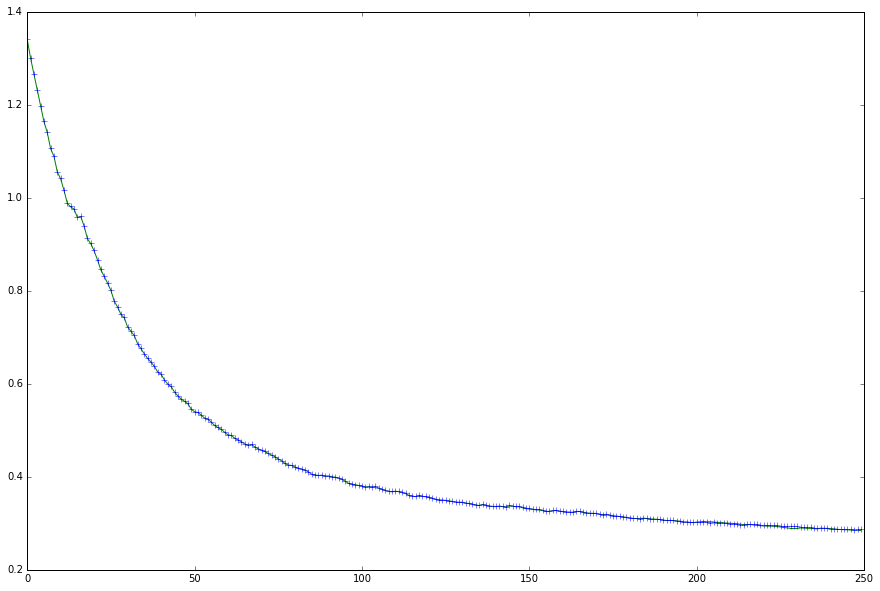

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(skl_losses[:300], 'g')
#plt.plot(1.03*np.array(skl_losses[:300]),'r')
plt.plot(clf.losses_test, 'b+')
#plt.plot(clf_bag.losses_test, 'mo')
plt.show()

## Learning rate = 0.1

** sklearn **

In [76]:
skl_losses_2 = []
skl_clf_2 = GradientBoostingClassifier(learning_rate=.1, n_estimators=1, random_state=np.random.mtrand.RandomState(17), \
                                     init=ZeroEstimator(), verbose=1, warm_start=True)

for i in range(1000):
    skl_clf_2.fit(X_train, Y_train)
    skl_clf_2.n_estimators += 1
    skl_losses_2.append(L_log(Y_test, skl_clf_2.decision_function(X_test)))

      Iter       Train Loss   Remaining Time 
         1           1.2679            0.00s
      Iter       Train Loss   Remaining Time 
         2           1.1691            0.00s
      Iter       Train Loss   Remaining Time 
         3           1.0866            0.00s
      Iter       Train Loss   Remaining Time 
         4           1.0155            0.00s
      Iter       Train Loss   Remaining Time 
         5           0.9485            0.00s
      Iter       Train Loss   Remaining Time 
         6           0.8917            0.00s
      Iter       Train Loss   Remaining Time 
         7           0.8416            0.00s
      Iter       Train Loss   Remaining Time 
         8           0.7935            0.00s
      Iter       Train Loss   Remaining Time 
         9           0.7546            0.00s
      Iter       Train Loss   Remaining Time 
        10           0.7165            0.00s
      Iter       Train Loss   Remaining Time 
        11           0.6794            0.00s

** Бэггинг по 5 деревьев **

In [87]:
clf_bag_5 = GradientBoosting()
clf_bag_5.fit(X_train, Y_train, _basic_model=Bagging,
            _args = {},
            _X_val=X_test, _Y_val=Y_test, _n_estimators = 400, _learning_rate=0.1, _verbose = 1)
print accuracy_score(clf_bag_5.predict(X_test).round(), Y_test)

Iteration: 0 	, Train loss: 1.1541 	, Test loss: 1.1904 	
Iteration: 1 	, Train loss: 1.0486 	, Test loss: 1.0927 	
Iteration: 2 	, Train loss: 0.9656 	, Test loss: 1.0423 	
Iteration: 3 	, Train loss: 0.8931 	, Test loss: 1.0131 	
Iteration: 4 	, Train loss: 0.8337 	, Test loss: 0.9658 	
Iteration: 5 	, Train loss: 0.7831 	, Test loss: 0.9163 	
Iteration: 6 	, Train loss: 0.7382 	, Test loss: 0.8788 	
Iteration: 7 	, Train loss: 0.6988 	, Test loss: 0.8397 	
Iteration: 8 	, Train loss: 0.6632 	, Test loss: 0.8100 	
Iteration: 9 	, Train loss: 0.6293 	, Test loss: 0.7688 	
Iteration: 10 	, Train loss: 0.6008 	, Test loss: 0.7443 	
Iteration: 11 	, Train loss: 0.5750 	, Test loss: 0.7161 	
Iteration: 12 	, Train loss: 0.5507 	, Test loss: 0.6915 	
Iteration: 13 	, Train loss: 0.5288 	, Test loss: 0.6670 	
Iteration: 14 	, Train loss: 0.5097 	, Test loss: 0.6469 	
Iteration: 15 	, Train loss: 0.4911 	, Test loss: 0.6282 	
Iteration: 16 	, Train loss: 0.4736 	, Test loss: 0.6138 	
Iterati

In [95]:
clf_bag_5.fit(X_train, Y_train, _basic_model=Bagging,
            _args = {},
            _X_val=X_test, _Y_val=Y_test, _n_estimators = 300, _learning_rate=0.1, _verbose = 1)
print accuracy_score(clf_bag_5.predict(X_test).round(), Y_test)

Iteration: 0 	, Train loss: 0.0637 	, Test loss: 0.2415 	
Iteration: 1 	, Train loss: 0.0635 	, Test loss: 0.2413 	
Iteration: 2 	, Train loss: 0.0634 	, Test loss: 0.2415 	
Iteration: 3 	, Train loss: 0.0632 	, Test loss: 0.2414 	
Iteration: 4 	, Train loss: 0.0631 	, Test loss: 0.2413 	
Iteration: 5 	, Train loss: 0.0629 	, Test loss: 0.2409 	
Iteration: 6 	, Train loss: 0.0627 	, Test loss: 0.2409 	
Iteration: 7 	, Train loss: 0.0626 	, Test loss: 0.2407 	
Iteration: 8 	, Train loss: 0.0624 	, Test loss: 0.2406 	
Iteration: 9 	, Train loss: 0.0623 	, Test loss: 0.2404 	
Iteration: 10 	, Train loss: 0.0621 	, Test loss: 0.2402 	
Iteration: 11 	, Train loss: 0.0620 	, Test loss: 0.2400 	
Iteration: 12 	, Train loss: 0.0618 	, Test loss: 0.2401 	
Iteration: 13 	, Train loss: 0.0617 	, Test loss: 0.2400 	
Iteration: 14 	, Train loss: 0.0615 	, Test loss: 0.2400 	
Iteration: 15 	, Train loss: 0.0613 	, Test loss: 0.2396 	
Iteration: 16 	, Train loss: 0.0612 	, Test loss: 0.2395 	
Iterati

KeyboardInterrupt: 

** График **

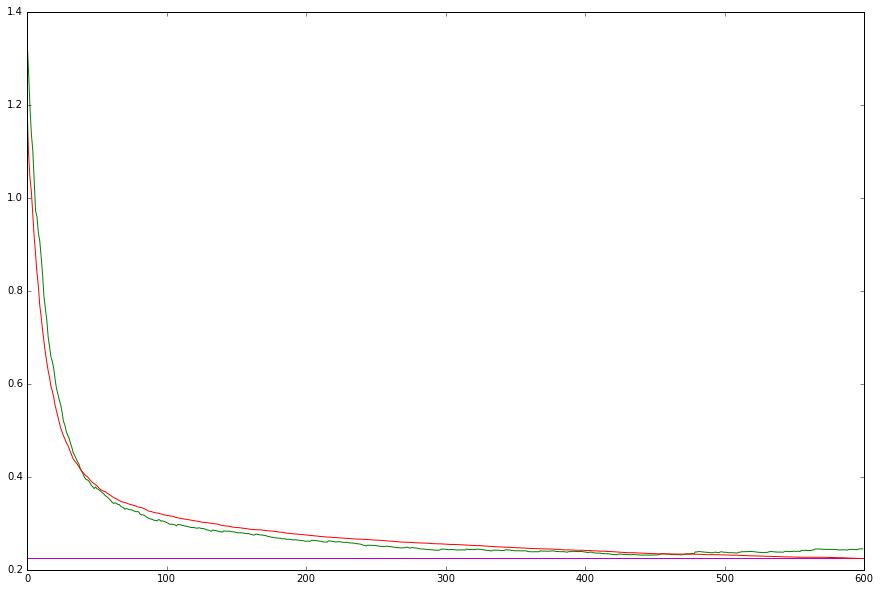

In [105]:
plt.figure(figsize=(15, 10))
plt.plot(np.array(skl_losses_2[:600]) * 1.03, 'g')
plt.plot([min(skl_losses_2[:600])] * 600, 'm')
plt.plot(clf_bag_5.losses_test, 'r')
plt.show()

In [99]:

print min(skl_losses_2), min(clf_bag_5.losses_test)

0.224585940711 0.224185814781


In [16]:
def loss(y, predict):
    f = 1 / (1 + np.exp(-predict))
    return np.mean(- y * np.log(f) - (1 - y) * np.log(1 - f))

In [ ]:
loss()